# Measurement Extraction of Pre-processed Filament

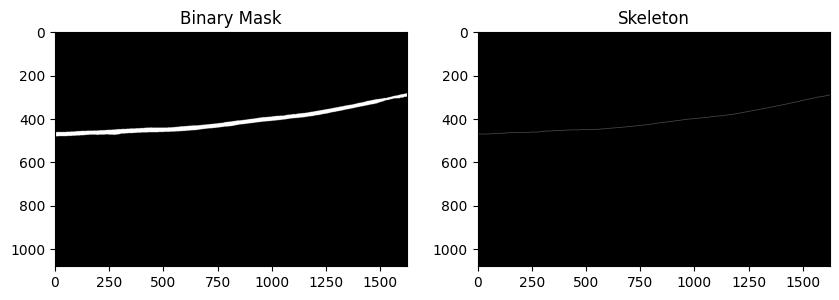

In [ ]:
# Step 1: Skeleton Extraction
from skimage.morphology import skeletonize
import numpy as np
import cv2
import matplotlib.pyplot as plt

"""
Load the binary mask and compute the skeleton
"""

final_filament = r"F:\FILAMENT\images\processed_filament.jpg"
mask = cv2.imread(final_filament, cv2.IMREAD_GRAYSCALE)
_, binary = cv2.threshold(mask, 0, 255,cv2.THRESH_BINARY + cv2.THRESH_OTSU)
binary = binary > 0
skeleton = skeletonize(binary)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.title("Binary Mask")
plt.imshow(binary.astype(np.uint8) * 255, cmap="gray")
plt.subplot(1,2,2)
plt.title("Skeleton")
plt.imshow(skeleton.astype(np.uint8) * 255, cmap="gray")

plt.show()

In [16]:
# Step 2: Width Measurement
PIXEL_TO_CM = 0.02645833333  # Example conversion factor
"""
Compute the distance transform and measure widths at skeleton points
"""
dist_transform = cv2.distanceTransform(mask, cv2.DIST_L2, 5)
width_px = dist_transform[skeleton] * 2
width_cm = width_px * PIXEL_TO_CM
print(f"Measured Widths (cm): {width_cm}")

# width statistics for overall quality of the filament
mean_width = np.mean(width_cm)
std_width = np.std(width_cm)
print(f"Mean Width: {mean_width:.2f} cm")
print(f"Width Std Dev: {std_width:.2f} cm")

# local width variation for bulge/neck detection
width_cm_smooth = np.convolve(width_cm, np.ones(5)/5, mode="valid")
local_mean = (width_cm_smooth[:-1] + width_cm_smooth[1:]) / 2
local_change = np.abs(np.diff(width_cm_smooth)) / local_mean
max_local_change = np.max(local_change)
print(f"Max Local Width Change: {max_local_change:.2%}")


Measured Widths (cm): [0.21166667 0.26458335 0.3175     ... 0.5291667  0.5291667  0.47625002]
Mean Width: 0.50 cm
Width Std Dev: 0.07 cm
Max Local Width Change: 20.68%


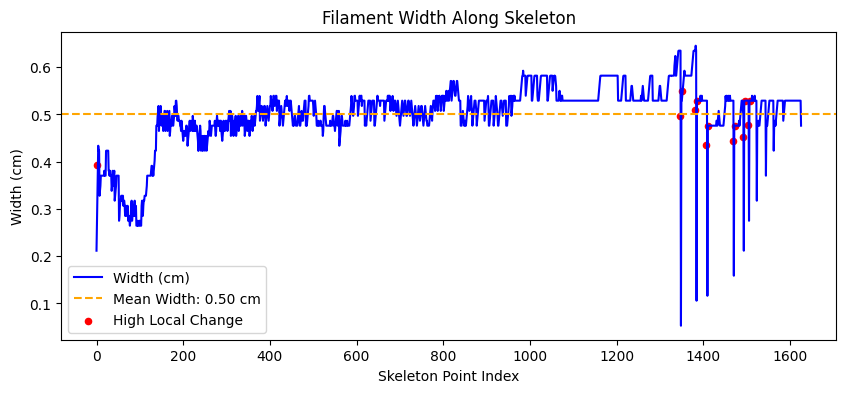

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Plot widths along skeleton
plt.figure(figsize=(10,4))
plt.plot(width_cm, label="Width (cm)", color='blue')
plt.axhline(mean_width, color='orange', linestyle='--', label=f"Mean Width: {mean_width:.2f} cm")

# Optional: highlight high local change regions
threshold = np.mean(width_cm_smooth) * 0.1  # example 10% change
high_change_idx = np.where(local_change > 0.1)[0]
plt.scatter(high_change_idx + 2, width_cm_smooth[high_change_idx+2], color='red', s=20, label="High Local Change")

plt.xlabel("Skeleton Point Index")
plt.ylabel("Width (cm)")
plt.title("Filament Width Along Skeleton")
plt.legend()
plt.show()


In [ ]:
# Step 3: Straightness Analysis

"""
Compute deviations from the best-fit line along the skeleton
"""
coords = np.column_stack(np.where(skeleton))
mean = coords.mean(axis=0)
U, S, Vt = np.linalg.svd(coords - mean, full_matrices=False)
# unit vector along the best-fit line
best_fit_direction = Vt[0]

coords_centered = coords - mean # center coordinates for distance calculation
dx, dy = best_fit_direction # unit vector components

# cross product of each skeleton point to the best-fit line (how far off the line it is)
distances_px = np.abs(
    coords_centered[:, 0] * dy -
    coords_centered[:, 1] * dx
)
print("distances:", distances_px)
distances_cm = distances_px * PIXEL_TO_CM
max_deviation = np.max(distances_cm)
mean_deviation = np.mean(distances_cm)
print(f"Mean Deviation from Straight Line: {mean_deviation:.2f} cm")
print(f"Max Deviation from Straight Line: {max_deviation:.2f} cm")


distances: [34.34824233 33.46121296 32.57418359 ... 20.15300789 23.33985655
 22.45282718]
Mean Deviation from Straight Line: 0.31 cm
Max Deviation from Straight Line: 0.91 cm


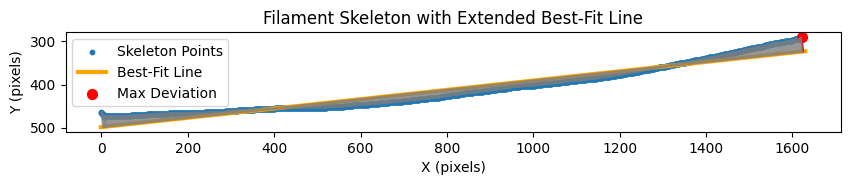

In [ ]:
# Visualization of skeleton and best-fit line with deviations

max_idx = np.argmax(distances_cm)  # index of point with max deviation

# Project all points onto the line to get range
projections = ( (coords - mean) @ best_fit_direction )
t_min, t_max = projections.min() - 5, projections.max() + 5  
t = np.linspace(t_min, t_max, 200)

# Best-fit line coordinates (horizontal view)
line_x = mean[1] + t * dy
line_y = mean[0] + t * dx

plt.figure(figsize=(10,4))  

# Skeleton points
plt.scatter(coords[:,1], coords[:,0], s=10, label="Skeleton Points")

# Best-fit line
plt.plot(line_x, line_y, color='orange', linewidth=3, label="Best-Fit Line") 

# Draw perpendicular lines (light gray) and highlight max deviation
for i in range(len(coords)):
    px, py = coords[i]
    proj_len = ( (px - mean[0])*dx + (py - mean[1])*dy )
    proj_x = mean[1] + proj_len * dy
    proj_y = mean[0] + proj_len * dx
    color = 'red' if i == max_idx else 'gray'
    alpha = 1.0 if i == max_idx else 0.3
    plt.plot([py, proj_x], [px, proj_y], color=color, alpha=alpha)

# Highlight max deviation point
plt.scatter(coords[max_idx,1], coords[max_idx,0], color='red', s=50, label="Max Deviation")

plt.gca().invert_yaxis() 
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel("X (pixels)")
plt.ylabel("Y (pixels)")
plt.title("Filament Skeleton with Extended Best-Fit Line")
plt.legend()
plt.show()
